In [0]:
from fastai import *
from fastai.vision import *

In [0]:
defaults.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [107]:
defaults.device

'cuda:0'

In [0]:
path = untar_data(URLs.PETS)

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
path_img = path/'images'

In [0]:
src = (ImageList.from_folder(path_img)
       .split_by_rand_pct(0.2, seed=44)
       .label_from_re(r'/([^/]+)_\d+.jpg$')
      )

In [0]:
data = (src.transform(tfms, size=224)
        .databunch(bs=64).normalize(imagenet_stats))

In [0]:
import torch.nn as nn
import math


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [85]:
!wget https://raw.githubusercontent.com/focus-start/ML_DEV_course_v1/master/8/mobilenet_v2.pth.tar

--2019-04-07 08:46:56--  https://raw.githubusercontent.com/focus-start/ML_DEV_course_v1/master/8/mobilenet_v2.pth.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14205652 (14M) [application/octet-stream]
Saving to: ‘mobilenet_v2.pth.tar.4’

mobilenet_v2.pth.ta 100%[===================>]  13.55M  83.5MB/s    in 0.2s    

2019-04-07 08:46:57 (83.5 MB/s) - ‘mobilenet_v2.pth.tar.4’ saved [14205652/14205652]



In [0]:
MN2 = MobileNetV2(n_class=1000)
state_dict = torch.load('mobilenet_v2.pth.tar') # add map_location='cpu' if no gpu
MN2.load_state_dict(state_dict)

In [16]:
MN2

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(96

In [32]:
len(data.y.classes)

37

In [0]:
MN2.classifier[1] = nn.Linear(1280,37)

In [0]:
learn = Learner(data, MN2, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy])

In [35]:
learn.split([MN2.features[9], MN2.classifier[0]])

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
basset_hound,boxer,Ragdoll,pomeranian,British_Shorthair
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chihuahua,Bombay,Bombay,american_bulldog,Bengal
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    

In [0]:
learn.freeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


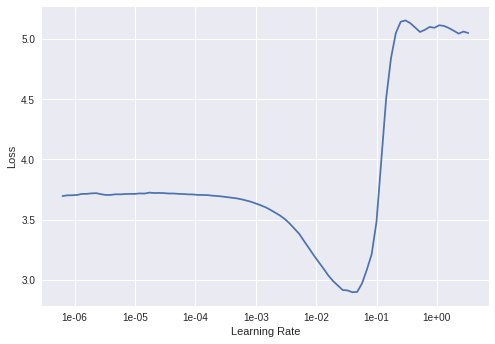

In [38]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.130208,0.446382,0.872124,01:53


In [41]:
learn.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.590726,0.356859,0.898512,01:52


In [87]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [99]:
learn.export(file = '/content/gdrive/My Drive/my_model2.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MobileNetV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type InvertedResidual. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
learn = load_learner(path = '/content/gdrive/My Drive', file='my_model2.pkl')

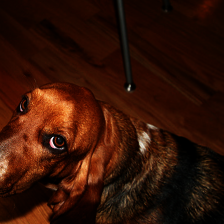

In [102]:
img = data.train_ds[0][0]
img

In [103]:
learn.predict(img)

(Category basset_hound,
 tensor(14),
 tensor([1.3631e-03, 9.1173e-04, 1.1050e-06, 2.4367e-05, 6.2167e-05, 6.9871e-05,
         4.6436e-06, 7.8204e-07, 5.9633e-06, 4.0052e-05, 3.0755e-05, 4.9740e-04,
         8.0536e-04, 1.3568e-01, 5.1148e-01, 2.1301e-01, 4.8991e-03, 1.6490e-03,
         1.5187e-02, 4.3607e-04, 4.2173e-02, 4.9027e-06, 8.3182e-06, 3.5085e-06,
         8.7297e-06, 9.9678e-05, 4.8438e-02, 7.3495e-05, 3.8449e-06, 2.4704e-05,
         1.0072e-04, 2.5348e-06, 3.7628e-05, 1.4455e-02, 7.6630e-03, 3.3853e-04,
         4.0125e-04]))